# Steel Plate Defect Classification

This notebook is authored by ```Ian Feekes``` as part of a kaggle competition.

If you are interested in getting in touch over my work, feel free to:
* Email me at ```ianfeekes@gmail.com```
* Message me through linkedin at ```https://linkedin.com/in/ianfeekes```.

## ⚙️ Initial Configuration

To allow offline work, I downloaded the files locally. The files can be retreived with the api command:
```bash
 sh% kaggle competitions download -c playground-series-s4e3
 ```

We note that the data is generated synthetically from a deep-learning model trained on the following data:

https://archive.ics.uci.edu/dataset/198/steel+plates+faults

### 📕 Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy import stats
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# XGBoost - may not need them all
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import log_loss

### Custom Functions

### ⬇️ Loading the Data

In [2]:
df = pd.read_csv('train.csv')
df.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,584,590,909972,909977,16,8,5,2274,113,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,1,808,816,728350,728372,433,20,54,44478,70,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,3,781,789,3353146,3353173,210,16,29,3202,114,...,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,4,1540,1560,618457,618502,521,72,67,48231,82,...,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1


## 🔎 Exploratory Data Analysis

### IBM Learning Stuff

Normalization is a way to bring all data into a similar range for more useful comparison. Binning is good for creating categories from a set of numerical variables.

In [3]:
df_copy = df.copy()
df_copy['id'] = df_copy['id'] + 1
df_copy.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,1,584,590,909972,909977,16,8,5,2274,113,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,2,808,816,728350,728372,433,20,54,44478,70,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,3,39,192,2212076,2212144,11388,705,420,1311391,29,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,4,781,789,3353146,3353173,210,16,29,3202,114,...,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,5,1540,1560,618457,618502,521,72,67,48231,82,...,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1


Missing values tend to be **?**, **N/A**, **0**, or **""** or **"NaN"**

* First option is going back and infering manually what it should be
* second option is to drop the variable or just the single entries where missing values are found
* replace missing values (one can do this with **mean**) or for categorical variables one could replace missing values with the categorical **mode**. One can 

In [4]:
sum(df_copy.isna().sum())

0

This will just drop the missing values (or at least the **na** values)
Can also do:
```python
inplace=True
```

In [5]:
df_copy.dropna()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,1,584,590,909972,909977,16,8,5,2274,113,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,2,808,816,728350,728372,433,20,54,44478,70,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,3,39,192,2212076,2212144,11388,705,420,1311391,29,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,4,781,789,3353146,3353173,210,16,29,3202,114,...,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,5,1540,1560,618457,618502,521,72,67,48231,82,...,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19214,19215,749,757,143210,143219,17,4,4,2193,122,...,-0.1429,0.0044,0.2901,0,0,0,1,0,0,0
19215,19216,723,735,2488529,2488541,231,17,26,27135,104,...,0.7222,-0.0989,0.5378,0,0,0,0,0,0,1
19216,19217,6,31,1578055,1578129,780,114,98,71112,41,...,0.7719,-0.4283,0.9997,1,0,0,0,0,0,0
19217,19218,9,18,1713172,1713184,126,13,26,14808,88,...,0.9610,-0.1162,0.3509,0,0,0,0,0,0,1


Replacing missing values:
The first argument is the value you want to replace e.g.
```python
np.NaN
```

The second argument is the value you want to fill it with e.g. the mean of the column

In [6]:
df_copy['id'] = df_copy['id'].replace(1, df_copy['id'].mean())
df_copy.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,9610,584,590,909972,909977,16,8,5,2274,113,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,2,808,816,728350,728372,433,20,54,44478,70,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,3,39,192,2212076,2212144,11388,705,420,1311391,29,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,4,781,789,3353146,3353173,210,16,29,3202,114,...,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,5,1540,1560,618457,618502,521,72,67,48231,82,...,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1


##### Data Formatting

Formatting ensures data is consistent and easily understandable. Some inconsistencies could be a city name e.g. "New York City" could be "NY", "N.Y", "New York", "NYC", etc.

You can apply calculations to an entire column

In [7]:
df_copy['X_Minimum_times_hundred'] = df_copy["X_Minimum"] * 100
df_copy['X_Minimum_times_hundred'].head()

0     58400
1     80800
2      3900
3     78100
4    154000
Name: X_Minimum_times_hundred, dtype: int64

Data types: you can use the 
```Python
DataFrame.dtype
```
method built-in with the DataFrame to get the datatype

In [8]:
df_copy['X_Minimum_times_hundred'].dtype

dtype('int64')

In [9]:
df_copy['X_Minimum_times_hundred'] = df_copy['X_Minimum_times_hundred'].astype('float')
df_copy['X_Minimum_times_hundred'].dtype

dtype('float64')

In [10]:
df_copy['X_Minimum_times_hundred'].head()

0     58400.0
1     80800.0
2      3900.0
3     78100.0
4    154000.0
Name: X_Minimum_times_hundred, dtype: float64

##### Data Normalization

You may want to normalize some features such as the ranges for numerical values like **X_Minimum**, **X_Maximum**, etc. so that they have the same impact.

Or consider a dataset with two features **Age** and **Income** where age is between ```0-100``` and income ranges from ```20,000 - 500,000```. 

Due to the varying ranges of the two variables, the variable with the higher range will vary the linear regression model. To avoid the bias, you need to move the variables into the same range e.g. from ```0.0-1.0```.

There are several approaches for data normalization. The first would be **simple feature scaling** wherein you just scale it from ```0.0-1.0``` by taking the old value over the max

In [11]:
df_copy['X_Minimum_times_hundred'] = df_copy['X_Minimum_times_hundred']/df_copy['X_Minimum_times_hundred'].max()
df_copy['X_Minimum_times_hundred'].head()

0    0.342522
1    0.473900
2    0.022874
3    0.458065
4    0.903226
Name: X_Minimum_times_hundred, dtype: float64

There is another data normalization approach called **Min-Max scaling** which calculates it as:

$x_{new} = (x_{old} - x_{min})/(x_{max}-x_{min})$

In [12]:
df_copy['X_Minimum_min_max'] = (df_copy['X_Minimum'] - df_copy['X_Minimum'].min())/(df_copy['X_Minimum'].max() - df_copy['X_Minimum'].min())
df_copy['X_Minimum_min_max'].head()

0    0.342522
1    0.473900
2    0.022874
3    0.458065
4    0.903226
Name: X_Minimum_min_max, dtype: float64

**z-score** scaling is the old values - mu / sigma

$ x_{new} = \dfrac{x_{old} - \mu}{\sigma}$

The results show where the data's z-score is in terms of standard deviation so the results are typically between -3 and positive 3 (but can be higher or lower if they are more standard deviations away)

In [13]:
df_copy['X_Min_z_score'] = (df_copy['X_Minimum'] - df_copy['X_Minimum'].mean())/df_copy['X_Minimum'].std()
df_copy['X_Min_z_score'].head()

0   -0.236772
1    0.184642
2   -1.262086
3    0.133846
4    1.561762
Name: X_Min_z_score, dtype: float64

##### 🗑️ Binning

**Binning** is when you group values together into bins. So you can group age into [0 to 5], [6 to 10], etc.

You can categorize things like **price** into multiple bins like ```low```, ```medium``` and ```high```.

In [14]:
bins = np.linspace(min(df_copy['X_Perimeter']), max(df_copy['X_Perimeter']), 4)
group_names = ['Low', 'Medium', 'High']
df['X_Perimeter_binned'] = pd.cut(df['X_Perimeter'], bins, labels=group_names, include_lowest=True)
# plt.hist(df['X_Perimeter_binned'])  
bins

array([2.000e+00, 2.519e+03, 5.036e+03, 7.553e+03])

In [15]:
df['X_Perimeter_binned'].value_counts()

X_Perimeter_binned
Low       19218
High          1
Medium        0
Name: count, dtype: int64

##### Categorical to Quantitative

Most statistical models can't take in objects or strings as input and only really expect numbers.

So if you have a car with a fuel type with ```'gas'```, ```'diesel'```, for the **fuel** feature, you encode them by creating new features for each category **fuel_gas** and **fuel_diesel** with values corresponding to if the categories are true. This is called **one-hot-encoding**

In pandas you can use the
```python
pd.get_dummies()
```
Which will automatically encode.

In [16]:
for key in df.dtypes.keys():
    if df.dtypes[key]=='int64':
        print(key)

id
X_Minimum
X_Maximum
Y_Minimum
Y_Maximum
Pixels_Areas
X_Perimeter
Y_Perimeter
Sum_of_Luminosity
Minimum_of_Luminosity
Maximum_of_Luminosity
Length_of_Conveyer
TypeOfSteel_A300
TypeOfSteel_A400
Steel_Plate_Thickness
Pastry
Z_Scratch
K_Scatch
Stains
Dirtiness
Bumps
Other_Faults


##### Descriptive Statistical Analysis

We note that the ```python describe()``` method skips over ```NaN``` values.

In [17]:
df.describe()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
count,19219.000000,19219.000000,19219.000000,1.921900e+04,1.921900e+04,19219.000000,19219.000000,19219.000000,1.921900e+04,19219.000000,...,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000
mean,9609.000000,709.854675,753.857641,1.849756e+06,1.846605e+06,1683.987616,95.654665,64.124096,1.918467e+05,84.808419,...,0.102742,-0.138382,0.571902,0.076279,0.059837,0.178573,0.029554,0.025235,0.247828,0.341225
std,5548.191747,531.544189,499.836603,1.903554e+06,1.896295e+06,3730.319865,177.821382,101.054178,4.420247e+05,28.800344,...,0.487681,0.120344,0.332219,0.265450,0.237190,0.383005,0.169358,0.156844,0.431762,0.474133
min,0.000000,0.000000,4.000000,6.712000e+03,6.724000e+03,6.000000,2.000000,1.000000,2.500000e+02,0.000000,...,-0.988400,-0.885000,0.119000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4804.500000,49.000000,214.000000,6.574680e+05,6.575020e+05,89.000000,15.000000,14.000000,9.848000e+03,70.000000,...,-0.272700,-0.192500,0.253200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9609.000000,777.000000,796.000000,1.398169e+06,1.398179e+06,168.000000,25.000000,23.000000,1.823800e+04,90.000000,...,0.111100,-0.142600,0.472900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,14413.500000,1152.000000,1165.000000,2.368032e+06,2.362511e+06,653.000000,64.000000,61.000000,6.797800e+04,105.000000,...,0.529400,-0.084000,0.999400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,19218.000000,1705.000000,1713.000000,1.298766e+07,1.298769e+07,152655.000000,7553.000000,903.000000,1.159141e+07,196.000000,...,0.991700,0.642100,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


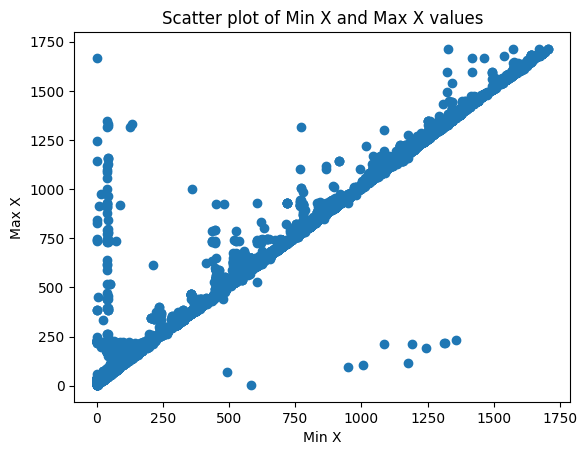

In [18]:
plt.scatter(df['X_Minimum'], df['X_Maximum'])
plt.title("Scatter plot of Min X and Max X values")
plt.xlabel("Min X")
plt.ylabel("Max X")
plt.show()

##### Grouping

It is useful looking at relationships between various variables. This can be done by the ```Groupby()``` method. Can be applied to categorical variables.

first you pick out the data columns of interest.

you can create a **pivot table** which has one variable displayed along the columns and another along the rows. This can be done by the ```DataFrame.pivot()``` method.

Another way of doing this is by doing a heatmap.

##### Analysis of Variance (ANOVA)

To analyze categorical variables we can use the ANOVA method, which can be used to find the correlation between different groups of a categorical variable.

The ANOVA test returns:
* F-test score: variation between the sample group means divided by variation within the sample group
* p-value: confidence degree:shows if something is statistically significant.

##### Correlation

Correlation measures to what extend two variables are independent. e.g. 
* **lung cancer** -> **smoking**
* **rain** -> **umbrella**

Correlation **does not** imply causation.

<Axes: xlabel='X_Minimum', ylabel='X_Maximum'>

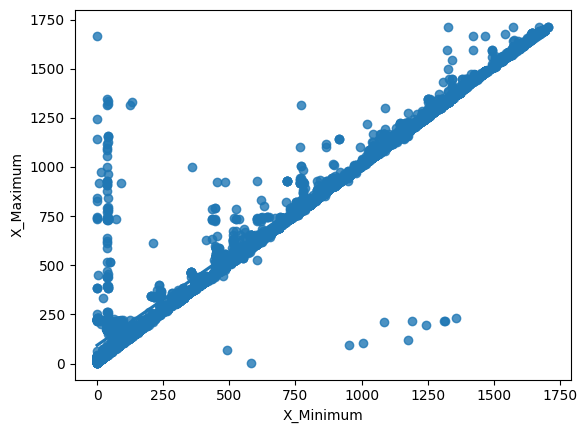

In [19]:
import seaborn as sns

sns.regplot(x="X_Minimum", y="X_Maximum", data=df)

##### Correlation Statistics

###### Pearson Correlation

Gives two values:
* Correlation coefficient
* P-value

A **Correlation coefficient** with a value close to 1 has a large positive relationship. A value close to -1 is a large negative relationship. Close to 0 is no relationship

A **P-value** < 0.0001 has Strong certainty in the result, with >0.1 has no certainty in the result.

#### Model Development

#### Linear Regression

**Simple Linear Regression** refers to one independent variable to make a prediction. This differs from **Multiple Linear Regression** which refers to multiple variables to make a prediction.

In **simple linear regression**, the predictor (independent) variable is $x$
The target (dependent) variable is $y$

The equation is $y=b_{0} + b_{1}x$

where $b_{0}$ is the **intercept**, and $b_{1}$ is the **slope**

There are often many factors and the certainty is shown as a factor of **noise** which is some constant that is added or removed from the prediction.

In [20]:
from sklearn.linear_model import LinearRegression

X = df[['X_Maximum']]
y = df[['X_Minimum']]

lm = LinearRegression()
lm.fit(X, y)

LinearRegression()

In [21]:
# lm.coef_
lm.intercept_

array([-83.62124388])

##### Multiple Linear Regression

**Multiple Linear Regression** is just used for multiple variables $x_{1}, x_{2}, ...  x_{n}.$

$y = b_{0} + b_{1}x_{1} + b_{2}x_{2} + ... b_{n}x_{n}$ for $n$ variables. Where $b_{0}$ is the intercept and the rest of the $b_{i}$ are the coefficient parameter for the corresponding variable.

##### Model Evaluation Using Visualization

**Regression Plots** are good estimates of the relationship between two variables with the strength of the correlation and the direction of the relationship (positive or negative).
* The X-axis is the independent variable
* The y-axis is the dependent variable
* Each point represents a different target point
* The fitted line represents the predicted value

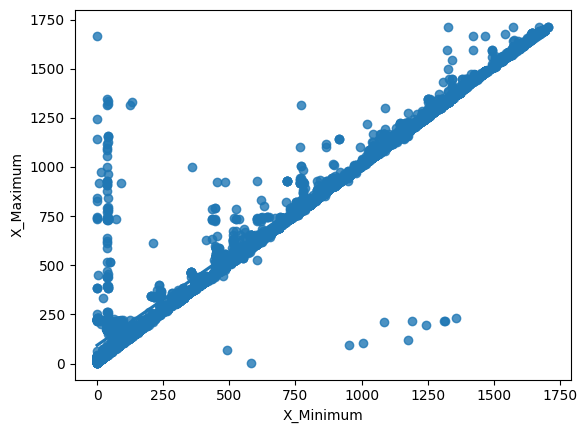

In [22]:
import seaborn as sns
sns.regplot(x="X_Minimum", y="X_Maximum", data=df)
plt.show()

The **Residual Plot** represents the error between actual values. Examining the predicted value and the actual value we see a difference.
* This difference is obtained simply by subtracting the predicted value and the actual target value.
* Then we plot that variable on the y-axis with the dependent variable on the X-axis.

For a **good** residual plot, one would expect the residual points to be plotted evenly around the mean $\mu$, with similar variance. There shouldn't be any curviture.
* If there is a curviture, this suggests that the linear assumption is incorrect.
* If the residuals start varying higher as $x$ increases then we know that the fit is incorrect.

In [23]:
lr = LinearRegression()
# lr.fit(np.array(df['X_Minimum']), np.array(df['X_Maximum']))

# sns.residplot(df[['X_Maximum', 'X_Minimum']])

A **Distribution Plot** counts the predicted value against the actual value. These plots are very useful for visualizing models with more than one independent variable.

##### Polynomial Regression

We transform our data into a polynomial and then use linear regression to fit the parameter. It's good for describing curvilinear relationships.

#### Preprocessing

The scikit-learn preprocessing module is really nice. You can do fit_transforms with scalers.

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

pipeline_input = [('scale', StandardScaler(), ('model', LinearRegression()))]
pipe = Pipeline(pipeline_input)
# Pipe.train(X[features], y)
# preds = Pipe.predict(X[features])

##### Measures for In-Sample Evaluation

A way to numerically determine how good the model fits our data.

**MSE** is calculated by $MSE = \sum_{i=1}^{n}(actual_{i} - predicted_{i})^2\div{n}$

**R-squared** aka the "Coefficient of Determination** is a measure to determine how close the data is to the fitted regression line: how close is the actual data to our estimated model.

As $R^{2} -> 0$ the line fits the data better.

It is calculated as $R^{2} = {MSE_{regression line}}\div{MSE_{\mu}}$

Some authors suggest that $R^{2} \geq{0.10}$

##### Prediction and Decision-Making

To determine if a model is a good fit, you should always use:
* Visualization
* Numerical measures for evaluation
* comparing between different models

##### Model Evaluation

**Model Evaluation** tells us how well our model performs in the real world.
We need to split our data in order to evaluate model performance on new data. When we have completed testing our model, we should use all the data to train the model and get the best performance.


```python
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=42)
```
The scikit learn train test split is good.

**Generalization Error** is a measure of how well our data dose at predicting previously unseen data. The error we obtain using our testing data is an approximation of this error. Using a lot of data gives us an accurate means of determining how our model will perform in the real world.

The idea is that if our training and testing data is split at some random split, it will have some error each time, and that error will be different based on the subsamples of the data that has been split. By performing **cross validation** multiple times, we are able to get a closer idea of what the generalization error is.

scikit learn has built-in cross validation methods where you can just specify the model, data, label, and folds.

In [25]:
from sklearn.model_selection import cross_val_score

# scores = cross_val_score(lr, x_data, y_data, cv=3)

**Underfitting** is where the model is too simple to fit the data.

**Overfitting** is where the model is too flexible and fits **noise** rather than the **function**

**Grid Search** takes the model or objects you want to train and calculates some scoring function throughout an array of hyperparameters, finding the best combination of hyperparameters.
* We select the hyperparameters that minimize the error.

### Basic Characteristics

#### Columns

In [26]:
df.columns

Index(['id', 'X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum',
       'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults', 'X_Perimeter_binned'],
      dtype='object')

#### Other

The **id** column is simply an index and doesn't provide any value and can hence be removed later on in the data pipeline.

In [27]:
len(df['id'].value_counts().keys()) == len(df)

True

There are ```19219``` entries in the dataframe with ```35``` variables.

In [28]:
df.shape

(19219, 36)

There should be no null values else this block will stop the flow of execution. This is noted on the original dataset.

In [29]:
assert(sum(df.isnull().sum()) == 0)

### 🎯 Target Analysis

According to the data card, the target categories are:

**Pastry, Z_Scratch, K_Scatch, Stains, Dirtiness, Bumps, Other_Faults**

It appears that most of the variables (maybe with the exception of **K_Scatch** and **Other_Faults**) are pre-encoded.

In [30]:
target = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']

for col in target:
    assert(col) in df.columns

This is a multi-label classification problem. Not a multi-classification problem. There are a bunch of intersecting rows

In [31]:
for idx, col in enumerate(target):
    j = idx+1
    df_temp = df[df[col]==1].copy()
    while j < len(target):
        df_temp2 = df[df[target[j]] == 1]
        # Perform an inner join to find intersecting rows
        intersecting_rows = pd.merge(df_temp, df_temp2, how='inner')

        # Count the number of intersecting rows
        num_intersecting_rows = len(intersecting_rows)
        if num_intersecting_rows > 0:
            print(f"{col} and {target[j]} intersection: {num_intersecting_rows}")
        j = j + 1


Pastry and K_Scatch intersection: 1
K_Scatch and Bumps intersection: 2
K_Scatch and Other_Faults intersection: 18


#### Domain Knowledge: Target Variable Classes

```Pastry``` is generally small patches or irregularities on the surfaces of the plates. This is usualy the outcome of failures in the manufactoring or transportation processes. They can affect the surface smoothness and appearance of the steel plate.

```Z_Scratch``` refers to narrow scratches or marks on the surface of the steel plate that run parallel to the rolling direction. FVarious factors such as handling, machining, or contact with abrasive materials during production or transportation can cause these scratches.

```K_Scratch``` is similar to a Z-scratch but runs perpendicular to the rolling direction. They can also be caused by handling, machining, or contact with abrasive materials during manufacturing or transportation process.

```Stains``` refer to discolored or contaminated areas on the surface of the steel plate. These can result from various sources such as rust, oil, grease, or other foreign substances that come into contact with the steel surface during processing, storage, or handling.

```Dirtiness``` indicates the presence of dirt or particulate matter on the surface of the steel plate. This can include various types of debris or contaminants that accumulate during manufacturing, handling, or storage process.

```Bumps``` are raised or protruding areas on the surface of the steel plate. These can be caused by irregularities in the manufacturing process, such as uneven rolling or cooling, or by physical damage during handling or transportation.

```Other faults``` encompasses a broader range of faults or defects not explicitly categorized in the other fault types listed. It could include various types of surface imperfections, irregularities, or abnormalities that affect the quality or usability of the steel plate.

In [32]:
for col in target:
    print(col)
    print(df[col].value_counts()[1])
    print()

Pastry
1466

Z_Scratch
1150

K_Scatch
3432

Stains
568

Dirtiness
485

Bumps
4763

Other_Faults
6558



### Other Variables

In [33]:
df.columns

Index(['id', 'X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum',
       'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults', 'X_Perimeter_binned'],
      dtype='object')

In [34]:
df.describe()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
count,19219.000000,19219.000000,19219.000000,1.921900e+04,1.921900e+04,19219.000000,19219.000000,19219.000000,1.921900e+04,19219.000000,...,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000
mean,9609.000000,709.854675,753.857641,1.849756e+06,1.846605e+06,1683.987616,95.654665,64.124096,1.918467e+05,84.808419,...,0.102742,-0.138382,0.571902,0.076279,0.059837,0.178573,0.029554,0.025235,0.247828,0.341225
std,5548.191747,531.544189,499.836603,1.903554e+06,1.896295e+06,3730.319865,177.821382,101.054178,4.420247e+05,28.800344,...,0.487681,0.120344,0.332219,0.265450,0.237190,0.383005,0.169358,0.156844,0.431762,0.474133
min,0.000000,0.000000,4.000000,6.712000e+03,6.724000e+03,6.000000,2.000000,1.000000,2.500000e+02,0.000000,...,-0.988400,-0.885000,0.119000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4804.500000,49.000000,214.000000,6.574680e+05,6.575020e+05,89.000000,15.000000,14.000000,9.848000e+03,70.000000,...,-0.272700,-0.192500,0.253200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9609.000000,777.000000,796.000000,1.398169e+06,1.398179e+06,168.000000,25.000000,23.000000,1.823800e+04,90.000000,...,0.111100,-0.142600,0.472900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,14413.500000,1152.000000,1165.000000,2.368032e+06,2.362511e+06,653.000000,64.000000,61.000000,6.797800e+04,105.000000,...,0.529400,-0.084000,0.999400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,19218.000000,1705.000000,1713.000000,1.298766e+07,1.298769e+07,152655.000000,7553.000000,903.000000,1.159141e+07,196.000000,...,0.991700,0.642100,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### ☑ Bounding Box Coordinates

##### X_Miminum

This represents the minimum X value of the bounding box described by the defect coordinates. "The minimum x-coordinate of the fault"

**Assumption**: I presume this is in pixel values of an image.

We can see that there is some notable variance exibited by the variable.

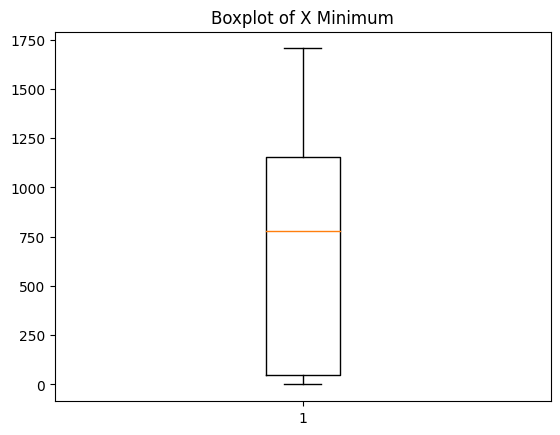

In [35]:
plt.boxplot(df['X_Minimum'])
plt.title("Boxplot of X Minimum")
plt.show()

We can see there are several clusters in the histogram including quite a few near-0 values.

**Hypothesis**: These may be due to scratches along the edges of an object

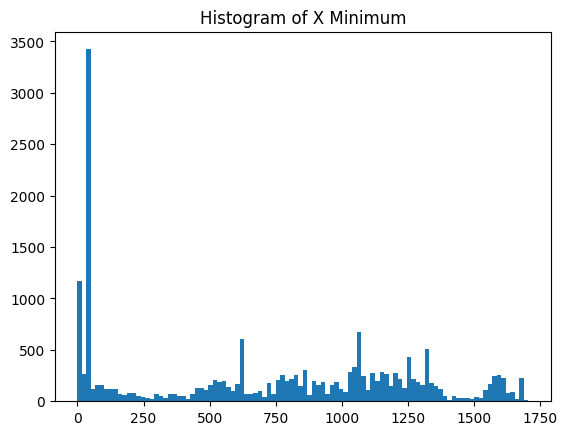

In [36]:
plt.hist(df['X_Minimum'], bins=100)
plt.title("Histogram of X Minimum")
plt.show()

The boxplot of the **X_Minimum** with the corresponding defect categories gives us some interesting insights:
* **Stains** tend to be right in the middle of the plates with a pretty normal distributiom
* **Other Faults** and **Pastry** also tend to be in the middle of the plates, albeit with higher variance
* **K_Scatch** is almost always towards the bottom of the plate, with plenty of outliers.
* **Bumps** and **Dirtiness** tend to be distributed around the center of the plates with a notable amount of variance
* **Z_Scratch** tends to be towards the bottom of the plates (Less so than the **K_Scatch**) with extremely wide variance and a notable left-lean.

**Hypothesis**: Other defects will follow similar patterns for X_Max and the Y values

In [37]:
sns.boxplot(x='defect', y='X_Minimum', data=df)
plt.title("Side-by-Side Boxplots of X_Minimunm")
plt.show()

ValueError: Could not interpret value `defect` for `x`. An entry with this name does not appear in `data`.

Indeed, it looks like for most of the defect types, the **X_Maximum** follows the distribution with the minimum values, simply tilted up a bit

The side-by-side boxplots for the **Minimum Y Values** reveal some insights and follow different patterns than the X values do.
1) Stains, tend to have the lowest y-min values with the tightest distribution
2) **K_Scatch** exhibits a notably higher mean with a nice normal distribution

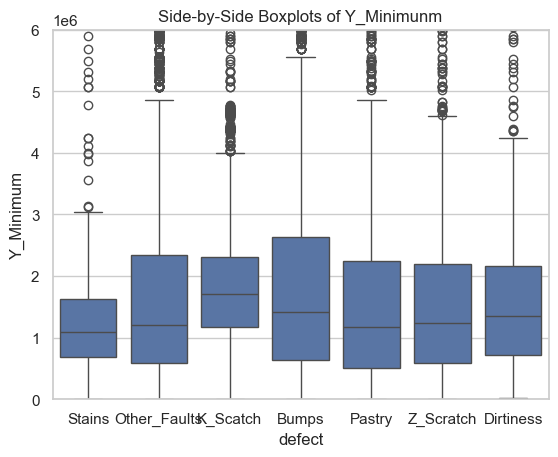

In [ ]:
sns.boxplot(x='defect', y='Y_Minimum', data=df)
plt.title("Side-by-Side Boxplots of Y_Minimunm")
plt.ylim(0, 6000000)
plt.show()

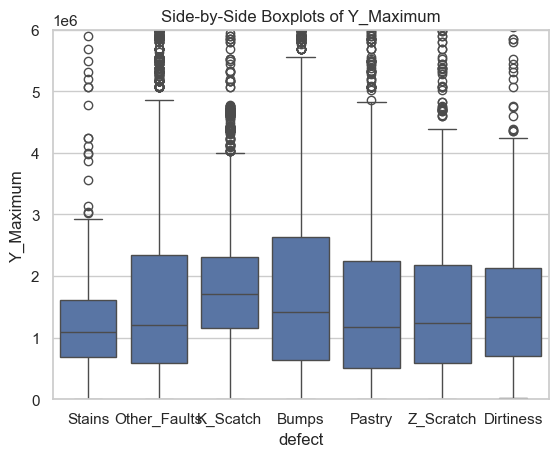

In [ ]:
sns.boxplot(x='defect', y='Y_Maximum', data=df)
plt.title("Side-by-Side Boxplots of Y_Maximum")
plt.ylim(0, 6000000)
plt.show()

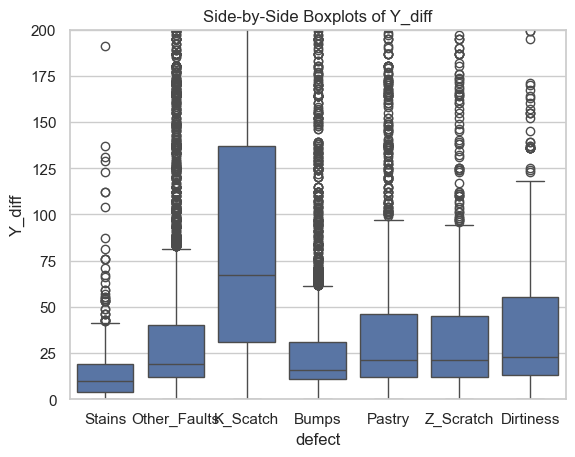

In [ ]:
df['Y_diff'] = abs(df['Y_Maximum'] - df['Y_Minimum'])

sns.boxplot(x='defect', y='Y_diff', data=df)
plt.title("Side-by-Side Boxplots of Y_diff")
# plt.ylim(0, 6000000)
plt.ylim(0, 200)
plt.show()

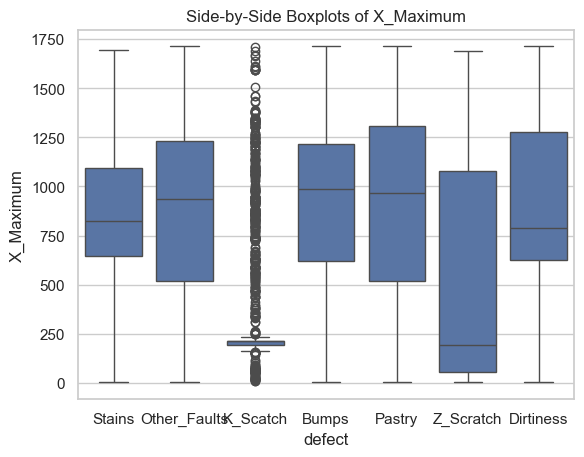

In [ ]:
sns.boxplot(x='defect', y='X_Maximum', data=df)
plt.title("Side-by-Side Boxplots of X_Maximum")
plt.show()

The **X_difference** (which for some reason can show up as negative?) follows some interesting patterns.
1) **Stains** tend to have very small lengths in X
2) **Z_Scratches** tend to have distributions along slightly larger lengths in the X axis
3) **K_Scatches** albeit having many outliers, have very large lengths in the X axis

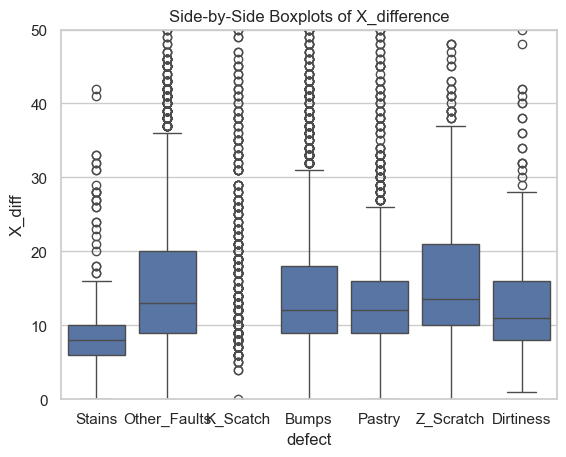

In [ ]:
df['X_diff'] = df['X_Maximum'] - df['X_Minimum']

sns.boxplot(x='defect', y='X_diff', data=df)
plt.title("Side-by-Side Boxplots of X_difference")
plt.ylim(0,50)
plt.show()

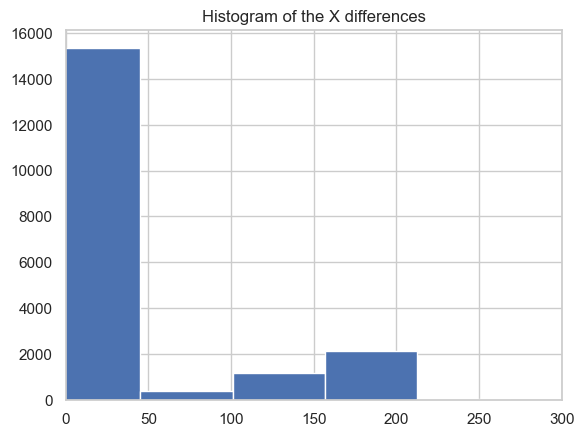

In [ ]:
plt.hist(df['X_diff'], bins=50)
plt.title("Histogram of the X differences")
plt.xlim(0, 300)
plt.show()

#### X_Maximum

**X_Maximum** is the max value for the defect bounding box and exibits similar behavior in high variance (and similar boundaries) seen by **X_Minimum**.

In [ ]:
df['X_Maximum'].describe()

count    19219.000000
mean       753.857641
std        499.836603
min          4.000000
25%        214.000000
50%        796.000000
75%       1165.000000
max       1713.000000
Name: X_Maximum, dtype: float64

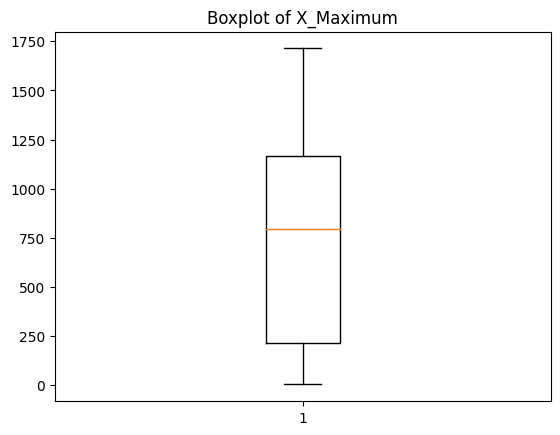

In [ ]:
plt.boxplot(df['X_Maximum'])
plt.title("Boxplot of X_Maximum")
plt.show()

The histogram for **X_Maximum** exibits very similar behavior compared with the histogram of the minimum values with clusters centered around ~```100```, ```500```, ```900```, ```1250```, and ```1600```.

Performing some form of binning with these two variables may be useful in the data processing stage.

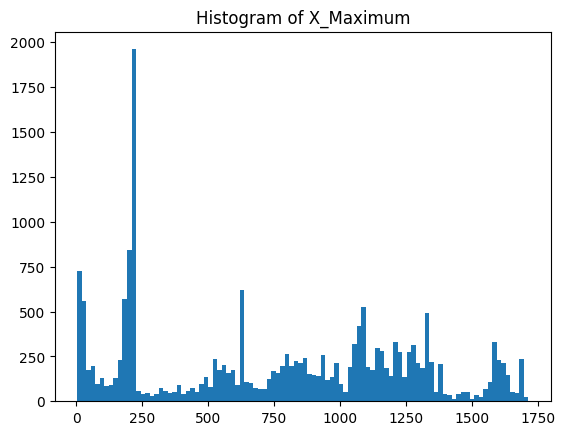

In [ ]:
plt.hist(df['X_Maximum'], bins=100)
plt.title("Histogram of X_Maximum")
plt.show()

### Pixels Areas

This is defined as "the total number of pixels in the identified defect or region in the steel plate".

This is not simply the area (xmax-xmin) * (ymax-ymin)

Most of the pixels areas are **very** small (between 0 and 20k pixels^2). 

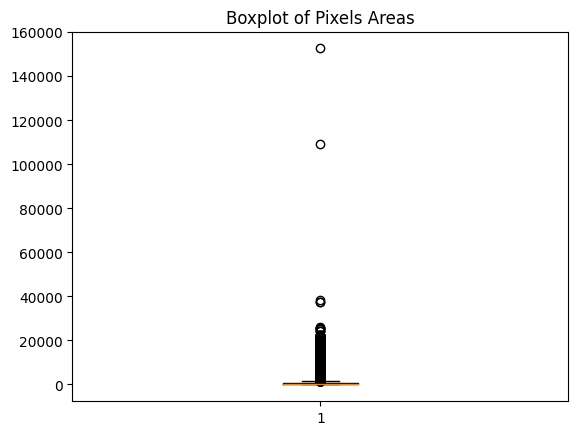

In [ ]:
plt.boxplot(df['Pixels_Areas'])
plt.title("Boxplot of Pixels Areas")
plt.show()

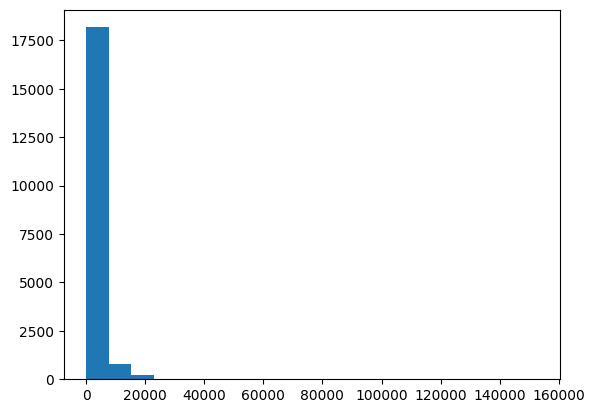

In [ ]:
plt.hist(df['Pixels_Areas'], bins=20)
plt.show()

In [ ]:
# Unencode the pre-one-hot-encoded columns for data visualization purposes
df['defect'] = df[target].idxmax(axis=1)
# df['defect'].head(5)

Most of the defect types tend to have very small areas with plenty of outliers. The ```K_Scatch``` seems to be the only defect type with any real distribution. 

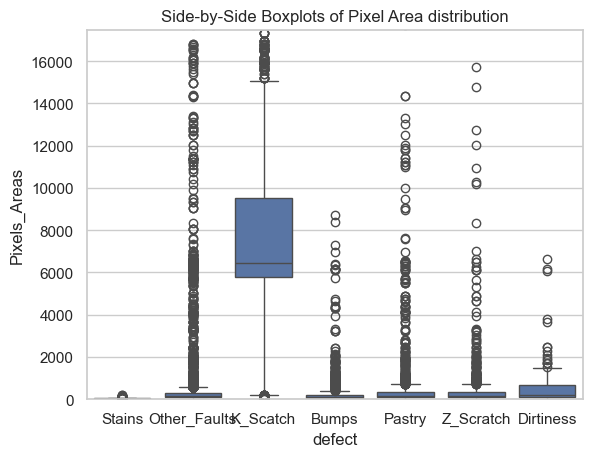

In [ ]:
# Set the style (optional)
sns.set(style="whitegrid")

# Create a boxplot
sns.boxplot(x='defect', y='Pixels_Areas', data=df)
plt.title("Side-by-Side Boxplots of Pixel Area distribution")
plt.ylim(0, 17500)

# Show the plot
plt.show()

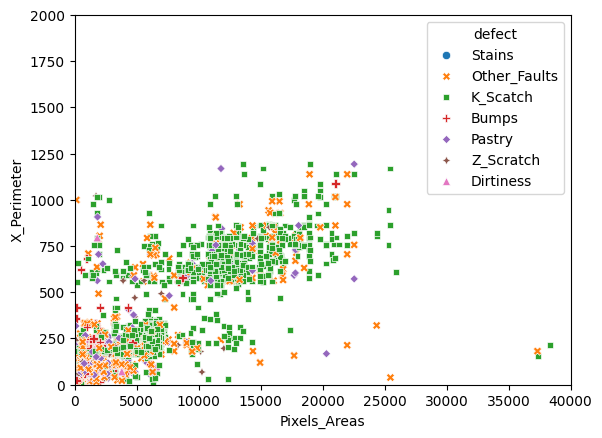

In [ ]:
# plt.scatter(df['Pixels_Areas'], )
sns.scatterplot(data=df, x='Pixels_Areas', y='X_Perimeter', hue='defect', style='defect')
plt.xlim(0, 40000)
plt.ylim(0, 2000)
plt.show()

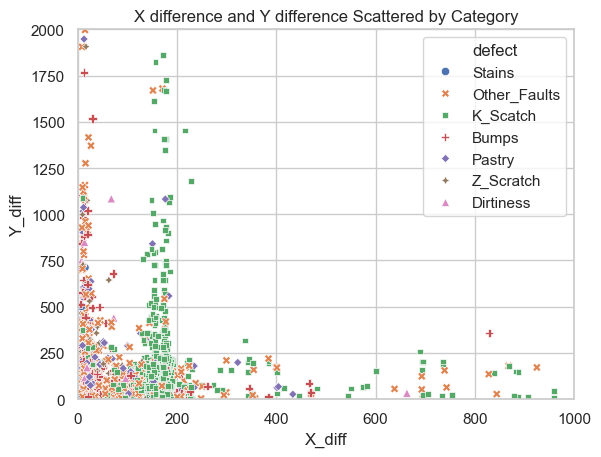

In [ ]:
sns.scatterplot(data=df, x='X_diff', y='Y_diff', hue='defect', style='defect')
plt.xlim(0, 1000)
plt.ylim(0, 2000)
plt.title("X difference and Y difference Scattered by Category")
plt.show()

In [ ]:
df.columns

Index(['id', 'X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum',
       'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults', 'X_Perimeter_binned', 'defect',
       'X_diff', 'Y_diff'],
      dtype='object')

#### Luminosity

Looks like with the distribution of luminosity you get the following observations:
* ```K_Scatch``` has significantly higher values than all other variables
* ```Dirtiness``` has a higher end of the quartiles than the other categories, along with exibiting significantly fewer outliers
* ```Z_Scratch``` also has a very slightly more high variance in luminosity sum

##### Sum Of Luminosity

Note that the **Sum of Luminosity** is the sum of the luminosity values for the entire defect area (so it may be worth checking out the ratio of luminosity to pixels area as well)

(0.0, 2000000.0)

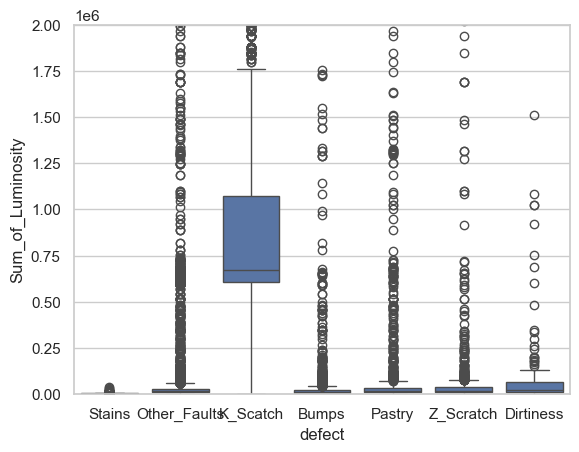

In [ ]:
sns.boxplot(data=df, x="defect", y="Sum_of_Luminosity")
plt.ylim(0, 2000000)

The sum of luminosity indeed seems to have a very high linear correlation wth the pixels areas which makes sense.

(0.0, 20000.0)

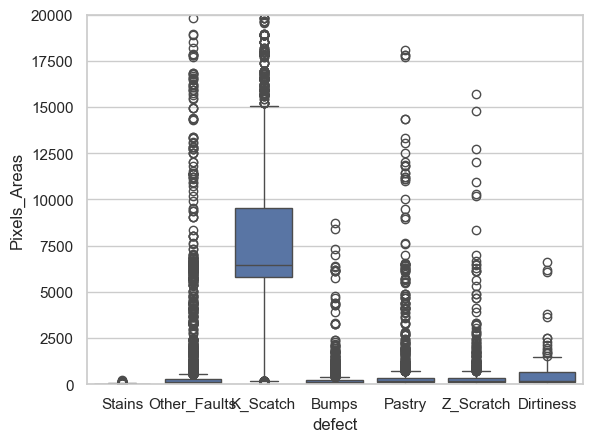

In [ ]:
sns.boxplot(data=df, x="defect", y="Pixels_Areas")
plt.ylim(0, 20000)

(70.0, 150.0)

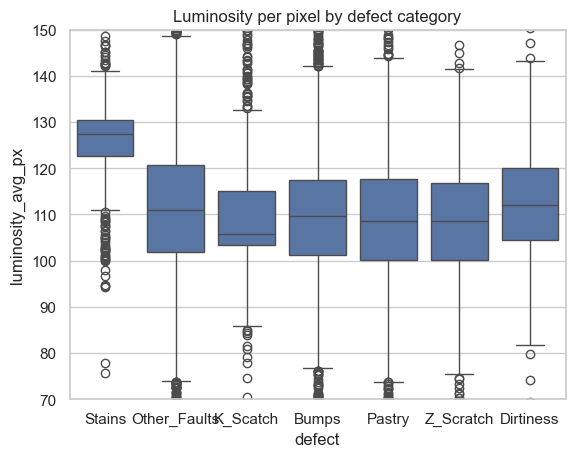

In [ ]:
df['luminosity_avg_px'] = df['Sum_of_Luminosity'] / df['Pixels_Areas']
sns.boxplot(data=df, x="defect", y="luminosity_avg_px")
plt.title("Luminosity per pixel by defect category")
plt.ylim(70, 150)

##### Minimum of Luminosity

* ```K_Scratches``` tend to have very low luminosity minimal values compared to the other variables.
* ```Stains``` show notably higher values with tighter variance compared to the other variables. 
* ```Dirtiness``` also tends to have slightly higher min-luminosity values with slightly tighter variance, though less-notable with Stains.

<Axes: xlabel='defect', ylabel='Minimum_of_Luminosity'>

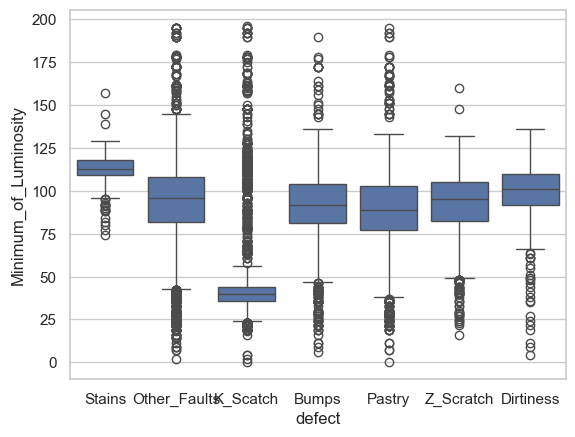

In [ ]:
sns.boxplot(data=df, x="defect", y="Minimum_of_Luminosity")
# plt.ylim(0, 200)

##### Maximum of Luminosity

* ```Stains``` persists with the trends of minimum luminosity in having generally higher values with tighter variance. The only variable that doesn't go parallel with the min values is ```K_Scratches``` which exibit higher values.

(90.0, 170.0)

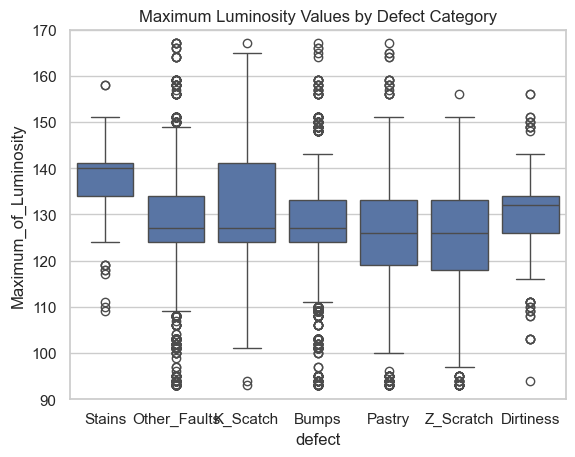

In [ ]:
sns.boxplot(data=df, x="defect", y="Maximum_of_Luminosity")
plt.title("Maximum Luminosity Values by Defect Category")
plt.ylim(90, 170)

#### Perimiters

##### X Perimeter

```K Scratches``` exibit much higher values for X perimiters which much higher varainces than the other variables.

When zoomed in, one can note that ```dirtiness``` and ```z scratches``` exibit higher values and variances than the other variables as well, with ```stains``` exibiting very small **X perimiters** with notably fewer outliers than the remaining variables.

(0.0, 100.0)

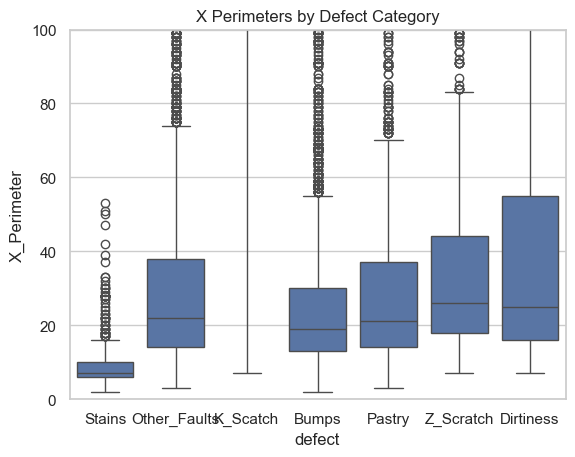

In [ ]:
sns.boxplot(data=df, x="defect", y="X_Perimeter")
plt.title("X Perimeters by Defect Category")
plt.ylim(0, 1000)
plt.ylim(0, 100)

##### Y Perimeter

Likewise with the **X Perimeter**, the highest values tend to be exibited by the ```K Scratch``` defect.

When zoomed in, all of the variables tend to follow similar trends to the **X Perimeter**, with slightly lower values for ```Z Scratch``` and slightly higher values for ```Pastry```

(0.0, 100.0)

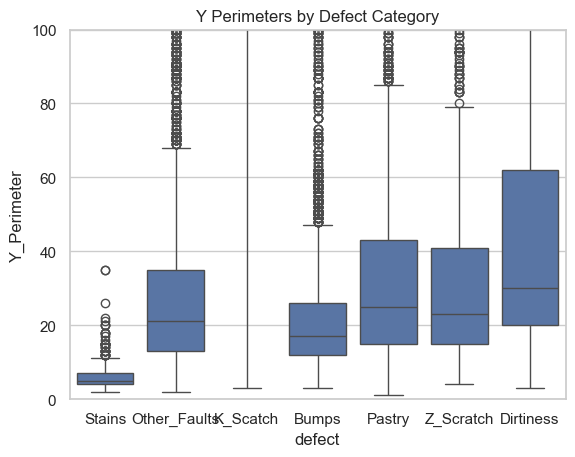

In [ ]:
sns.boxplot(data=df, x="defect", y="Y_Perimeter")
plt.title("Y Perimeters by Defect Category")
plt.ylim(0, 800)
plt.ylim(0, 100)

##### Feature: Perimeter Ratio

One idea is that the shape of the defects could be statistically useful. Certain defects like ```K Scratches``` are supposed to be perpendicular to the rolling direction whereas ```Z Scratches``` are supposed to be parallel to the rolling direction.

* The ```K_Scratches``` tend to be longer along the y-axis, nearly a 2:1 y:x ratio
* ```Pastry``` and ```Dirtiness``` tend to be longer along the y-axis
* ```Stains``` tend to be notably longer along the y-axis as well

(0.0, 5.0)

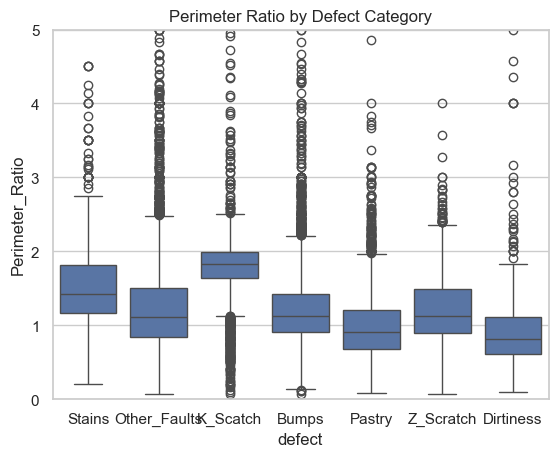

In [ ]:
df['Perimeter_Ratio'] = df['X_Perimeter'] / df['Y_Perimeter']
sns.boxplot(data=df, x="defect", y="Perimeter_Ratio")
plt.title("Perimeter Ratio by Defect Category")
plt.ylim(0, 5)

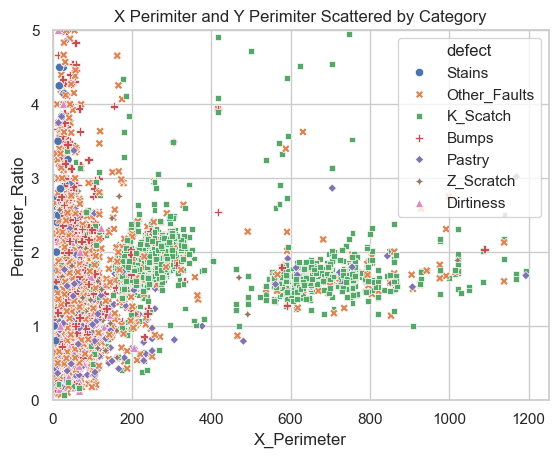

In [ ]:
sns.scatterplot(data=df, x='X_Perimeter', y='Perimeter_Ratio', hue='defect', style='defect')
plt.xlim(0, 1250)
# plt.xlim(0, 5)
# plt.ylim(0, 750)
plt.ylim(0, 5)
plt.title("X Perimiter and Y Perimiter Scattered by Category")
plt.show()

#### Material and Index Features

The types of steel aren't entirely mutually-exclusive because of a single entry, so we will probably just delete itso wecan remove the ```A400``` column and gain mutual-exclusivity

In [ ]:
df['TypeOfSteel_A300'].value_counts()

TypeOfSteel_A300
0    11480
1     7739
Name: count, dtype: int64

The ```A300``` variant tends tohave the most ```bumps``` and ```other faults``` whereas the ```A400``` variant has defects that represent more of the general sample

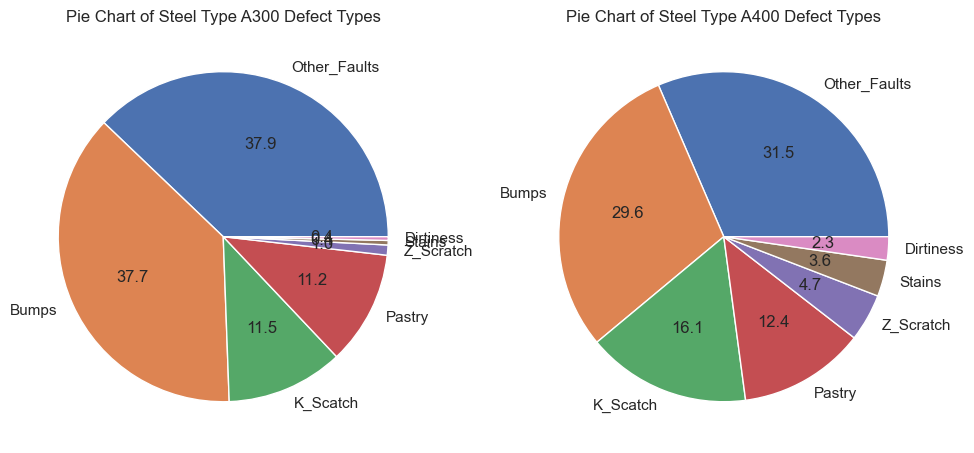

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
ax1.pie(df[df['TypeOfSteel_A300']==1]['defect'].value_counts(),
        labels=df['defect'].value_counts().keys(),
        autopct='%1.1f')
ax1.set_title("Pie Chart of Steel Type A300 Defect Types")

ax2.pie(df[df['TypeOfSteel_A400']==1]['defect'].value_counts(),
        labels=df['defect'].value_counts().keys(),
        autopct='%1.1f')
ax2.set_title("Pie Chart of Steel Type A400 Defect Types")

plt.tight_layout()
plt.show()

There are some very valuable observations to be made based on the thickness of the plates:
* ```K_Scratch``` is nearly always represented among plates of thickness ~ 40
* ```Stains``` is nearly always represented among plates of thickness ~ 50
* ```Z_Scratch``` is nearly always represented among plates ofthickness ~ 70

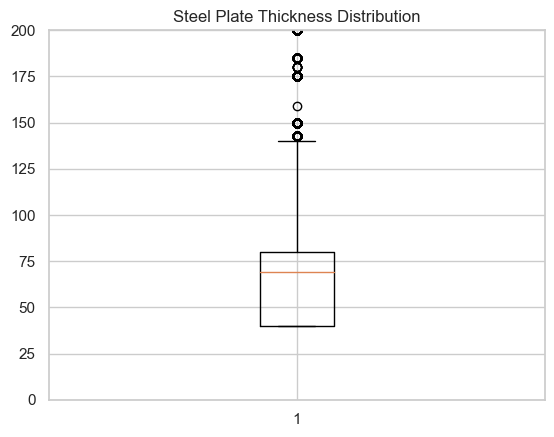

In [ ]:
plt.boxplot(df['Steel_Plate_Thickness'])
plt.title("Steel Plate Thickness Distribution")
plt.ylim(0, 200)
plt.show()

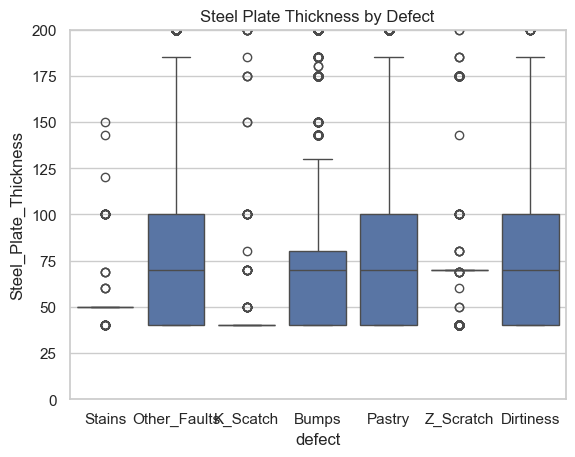

In [ ]:
sns.boxplot(data=df, x='defect', y='Steel_Plate_Thickness')
plt.title("Steel Plate Thickness by Defect")
plt.ylim(0, 200)
plt.show()

## Defining the Data Pipeline

In [ ]:
pipeline_functions = []

In [ ]:
"""
Drops the 'id' column from the dataframe parameter
"""
def remove_id(df):
    if 'id' in df.columns:
        return df
    df_ret = df.copy()
    df_ret = df_ret.drop('id', axis=1)
    return df_ret

pipeline_functions.append(remove_id)